# Initial Assessment: SPY
In this project, we simply rerun our base initial assessment workflow on SPY. 
SPY is the NYSEARCA ticker for the SPDR S&P 500 ETF Trust.
This ETF follows the S&P 500 index.
The workflow is based on analysis from the actual S&P 500 over a 50 year period (ending in 2024).
It uses historical data to assess simple trend fitting, autocorrelation and
robust statistics for estimating risk and return metrics.
The goal is to identify:
* sample freq;
* sample period;
* deviation event lengths (particularly for re allocation timeframes); and
* expected returns as a function of hold time.


## Setup


In [92]:
# Paths

# Analytics dir path *USER SET*
analyticsDir = '/Users/rtasseff/projects/condor_test/analytics'
# Data dir path *USER SET*
dataDir = '/Users/rtasseff/projects/tmp'

########################

## Setting paths in python
#import sys
#sys.path.insert(0, analyticsDir)

# Imports
#from data_mining import fetch_tickers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.tsa import stattools





## I Load SPY data 
We are using the full SPY history (1993-2024), manually downloaded.

In [67]:
spy_history = pd.read_csv(dataDir+'/spy_MAX.tab', sep='\t')

# Convert date column to datetime
spy_history['Date'] = pd.to_datetime(spy_history['Date'])

# Preference to see data start to end so flip it
spy_history.sort_values('Date', axis=0, ascending=True, inplace=True)

#take a look
spy_history.info()
spy_history


<class 'pandas.core.frame.DataFrame'>
Index: 8091 entries, 8090 to 0
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         8091 non-null   datetime64[ns]
 1   Open         8091 non-null   object        
 2   High         7964 non-null   float64       
 3   Low          7964 non-null   float64       
 4   Close*       7964 non-null   float64       
 5   Adj Close**  7964 non-null   float64       
 6   Volume       7964 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 505.7+ KB


,Date,Open,High,Low,Close*,Adj Close**,Volume
8090,1993-01-29,43.97,43.97,43.75,43.94,24.68,"1,003,200"
8089,1993-02-01,43.97,44.25,43.97,44.25,24.86,"480,500"
8088,1993-02-02,44.22,44.38,44.13,44.34,24.91,"201,300"
8087,1993-02-03,44.41,44.84,44.38,44.81,25.18,"529,400"
8086,1993-02-04,44.97,45.09,44.47,45.00,25.28,"531,500"
...,...,...,...,...,...,...,...
4,2024-09-10,548.36,549.15,543.38,548.79,548.79,"36,394,600"
3,2024-09-11,548.70,555.36,539.96,554.42,554.42,"75,248,600"
2,2024-09-12,555.01,559.40,552.74,559.09,559.09,"51,892,700"
1,2024-09-13,559.71,563.03,559.45,562.01,562.01,"39,310,500"


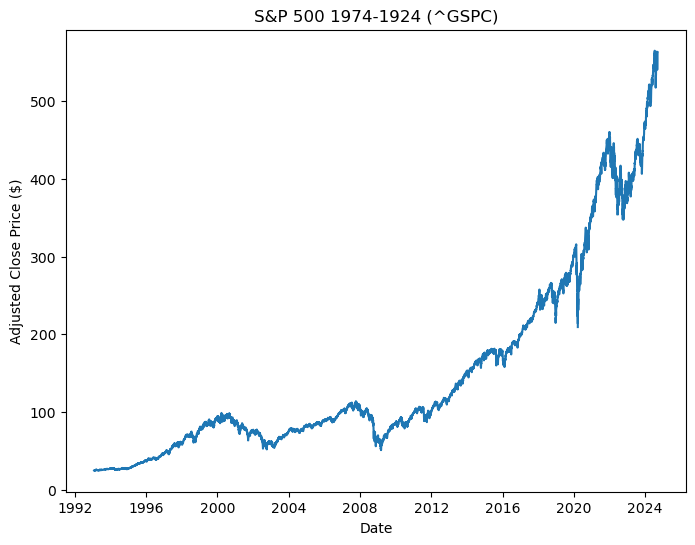

In [68]:
# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(spy_history['Date'], spy_history['Adj Close**'])
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.title('S&P 500 1974-1924 (^GSPC)')
plt.show()

## II Identify Trend 
Here we want to identify the overall market trend in the form
of a simple, closed-form analytical equation. 
We considered low order polynomial, exponential and log functions.
We assessed each based on fit and complexity using an information criterion.
Here we will use the Bayesian Information Criteria (BIC) and 
adjusted r-squared value built into the statsmodel library.

We found that polynomials improved both the BIC and 
the adj r-squared value up to order four.
We expect worsening results due to numerical instability at order 5 and higher.
The 4<sup>th</sup> order polynomial captured about 98% of variability.  
This fit was only slightly better than the 3<sup>rd</sup> order.
This was the same fit used in the S&P 500 data.
Interestingly the exponential polynomial did poorly
as compared to great performance on the S&P 500 data. 
However, this is probably due to the truncated time series of the SPY 
(30 vs 50 years).
Pre 2000 tech bubble (and repeal of Glass–Steagall) the market 
was fundamentally different, with much less variability.
This provided a long starting streak in the S&P 500 
that was relatively flat compared to post 2000 behavior.
The exp fit benefited from this time frame on the S&P 500, 
but SPY was not offered until 1993.


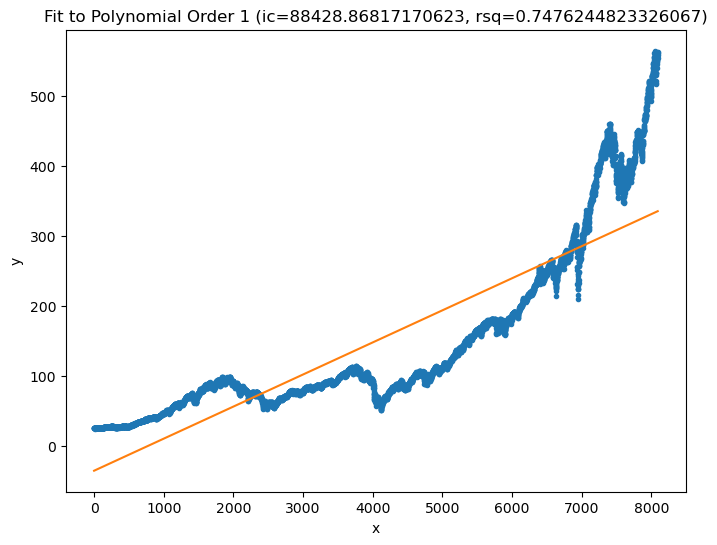

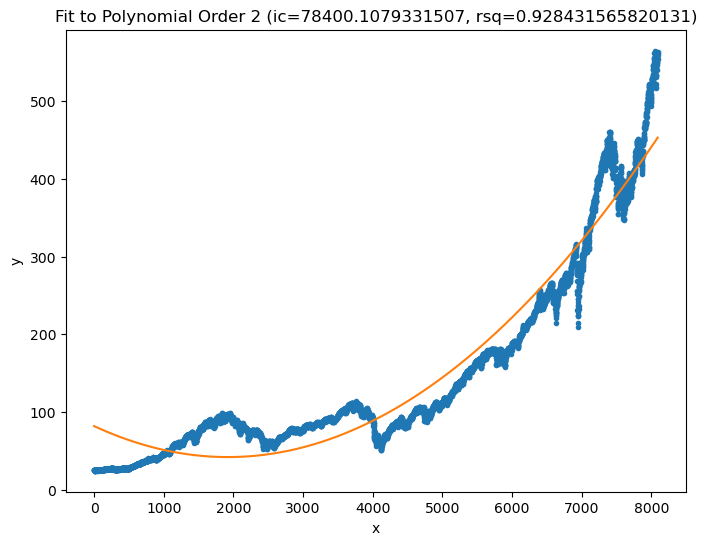

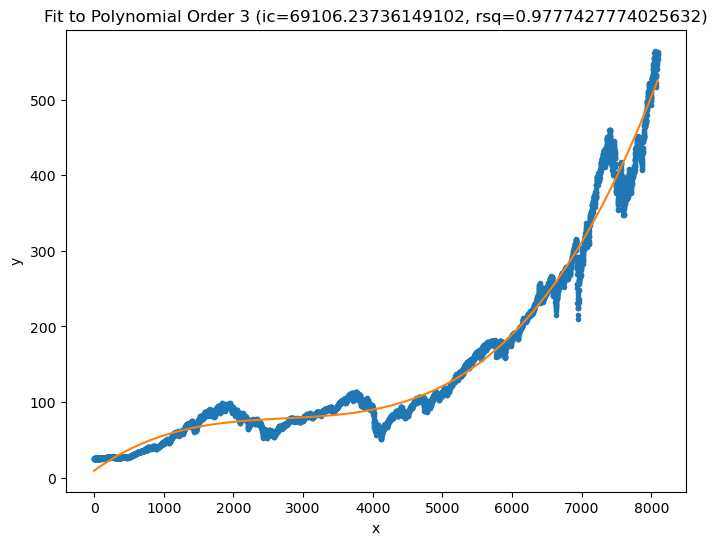

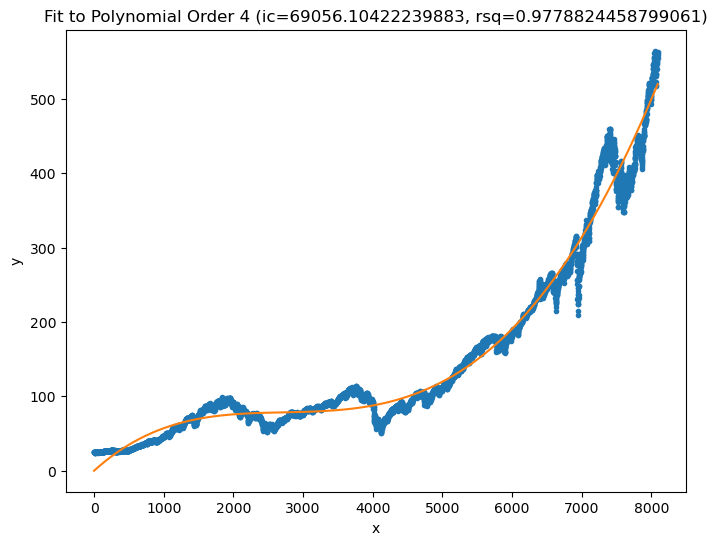

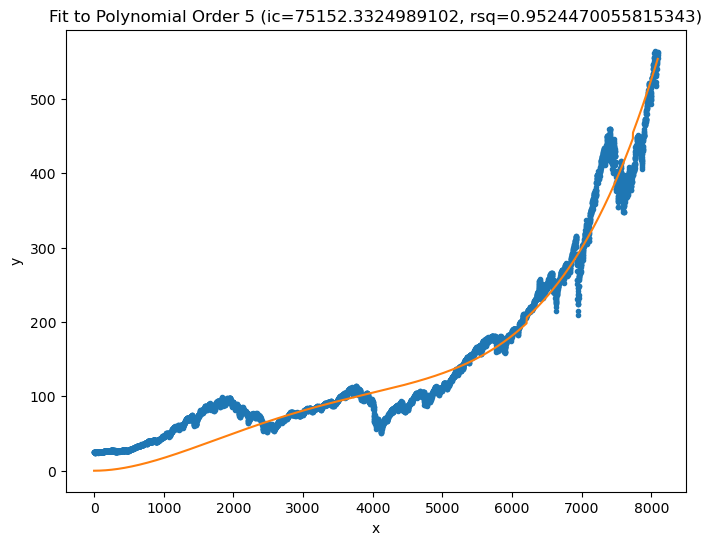

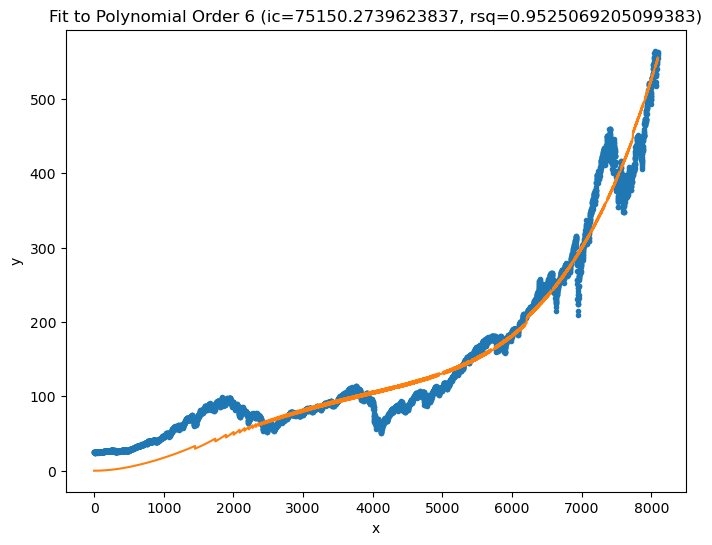

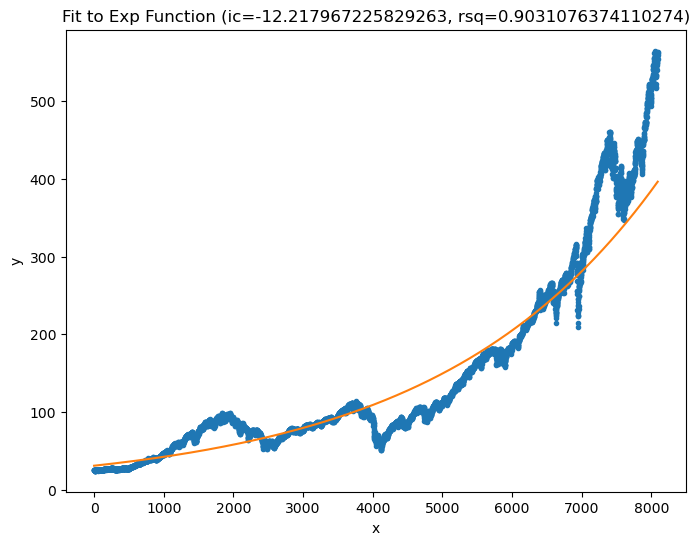

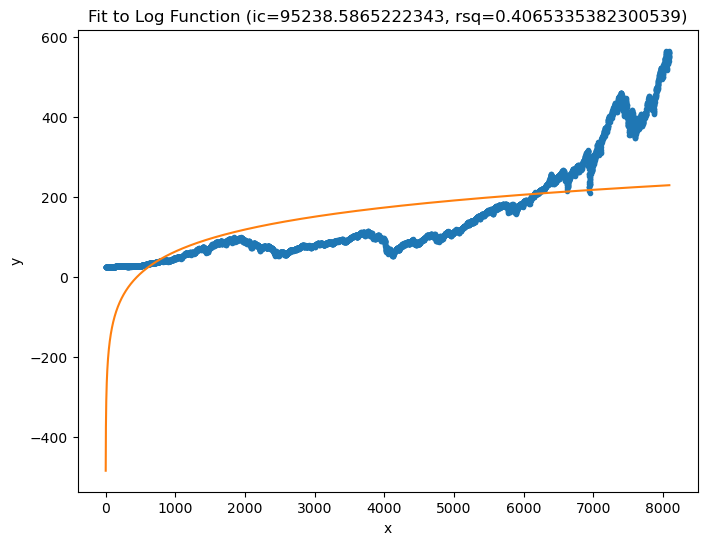

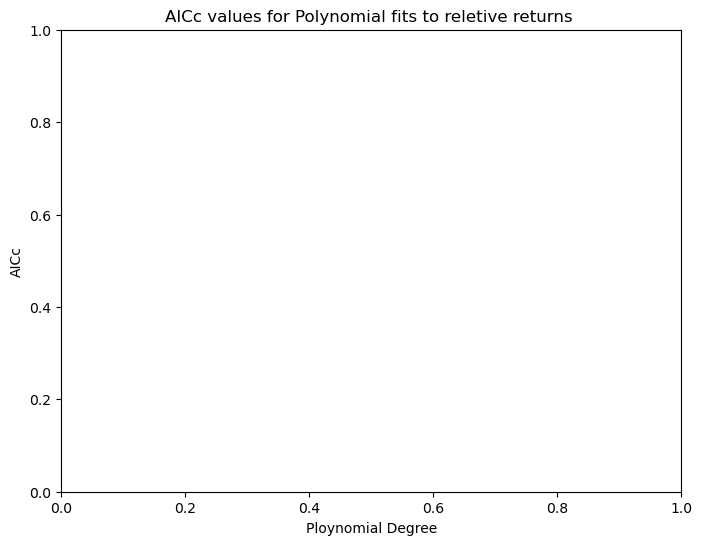

[88428.86817170623, 78400.1079331507, 69106.23736149102, 69056.10422239883, 75152.3324989102, 75150.2739623837, -12.217967225829263, 95238.5865222343]


In [69]:

# maximum order of polynomials (we exclude 0th) *USER SET*
maxPolyOrder = 6

##############

names = []
minIc = 1000
minIcIndex = -1
ics = []
rsqs = []

#x = np.arange(len(spy_history['Adj Close**']))
#y = spy_history['Adj Close**'].to_numpy()
#missing = np.isnan(y)
#keep = np.invert(missing)
#x = x[keep]
#y = y[keep]



def run_model(X,y):
    # statsmodels ordinary least squares regression model
    regr = OLS(y, X, missing='drop').fit()
    ic = regr.bic
    rsq = regr.rsquared_adj
    yHat = regr.predict(X)
    
    return ic, rsq, yHat, regr

# Run through all poly deg models
for i in range(maxPolyOrder):
    polyOrder = i+1
    name = 'Polynomial Order '+str(polyOrder)
    names.append(name)

    # Create X matrix
    if polyOrder == 1:
        X = add_constant(x.reshape(-1, 1))
    else:
        X = np.c_[X, x**polyOrder]

    ic, rsq, yHat, model = run_model(X,y)

    # Hack to capture the chosen fit of order 4, added posthock
    if polyOrder == 4:
        yHat_final = yHat
    
    ics.append(ic)
    rsqs.append(rsq)
    
    # Plot the data for sanity check
    plt.figure(figsize=(8, 6))
    plt.plot(x, y,'.',x,yHat,'-')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Fit to '+name+' (ic='+str(ic)+', rsq='+str(rsq)+')')
    plt.show()


# Run for exp function: y=Aexp(Bx) -> log(y)=log(A)+Bx
name = 'Exp Function'
names.append(name)

X = add_constant(x.reshape(-1, 1))
ic, rsq, yHatLog, model = run_model(X,np.log(y))
ics.append(ic)
rsqs.append(rsq)

## Hack to capture the chosen fit of order 4, added posthock
#yHat_final = np.exp(yHatLog)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x, y,'.',x,np.exp(yHatLog),'-')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fit to '+name+' (ic='+str(ic)+', rsq='+str(rsq)+')')
plt.show()

# Run for log function: y=A+Blog(x)
name = 'Log Function'
names.append(name)

X = add_constant(np.log(x+1).reshape(-1, 1))
ic, rsq, yHat, model = run_model(X,y)
ics.append(ic)
rsqs.append(rsq)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x, y,'.',x,yHat,'-')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fit to '+name+' (ic='+str(ic)+', rsq='+str(rsq)+')')
plt.show()

# Plot AICcs for inspection
plt.figure(figsize=(8, 6))
#plt.plot(np.arange(30)+1, ics,'.')
plt.xlabel('Ploynomial Degree')
plt.ylabel('AICc')
plt.title('AICc values for Polynomial fits to reletive returns ')
plt.show()

print(ics)
    

## III Sampling Frequency of Price
For any statistical analysis we have to determine how much time will pass
between t<sub>i</sub> and t<sub>i+1</sub> in our data set.
In our experience this, is often arbitrarily determined.
Here we will consider a more formal statistical approach. 
We want to maximize the number of sampling points while minimizing their dependence
since a proper statistical analysis would require statistically independent samples.
To do this, we consider the price is based on both a 'drift' and a 'noise' term.
The drift is defined by the trend (Section II).
By subtracting the expected value based on this trend, 
we are left with the noise term.
To ensure the noise term is statistically independent, 
we will select a sampling rate such that each point in our time series 
is independent with a 95% confidence.
Ultimately this is done by considering the elapsed time for the 
auto-correlation function to drop to a 95% confidence level of zero.

Interestingly, we found long time correlations in the ACF for the noise portion of this trend.
By design, the highest correlation for AC analysis is always t = 0.
However, we noted a large positive AC spike at ~1750 trading days 
(~7 years) and again at ~3500.
This suggests the deviation in price is correlated on a 7 year period
(recall 21 trading days per month; note the + AC holds for about 2 years in each spike).
Then drops down to negative or near zero correlation.
However, the zero value does remain in the 95% CI.

In the next section, we will reapply the analysis to the return.



[ 1.          0.98393417  0.98299209 ... -0.13317526 -0.13313326
 -0.13315176]


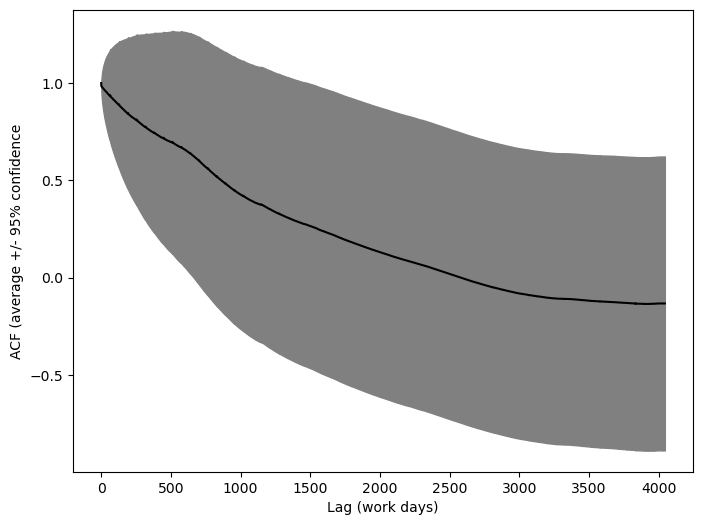

[ 1.          0.97478634  0.9703143  ... -0.0615153  -0.06112564
 -0.06071161]


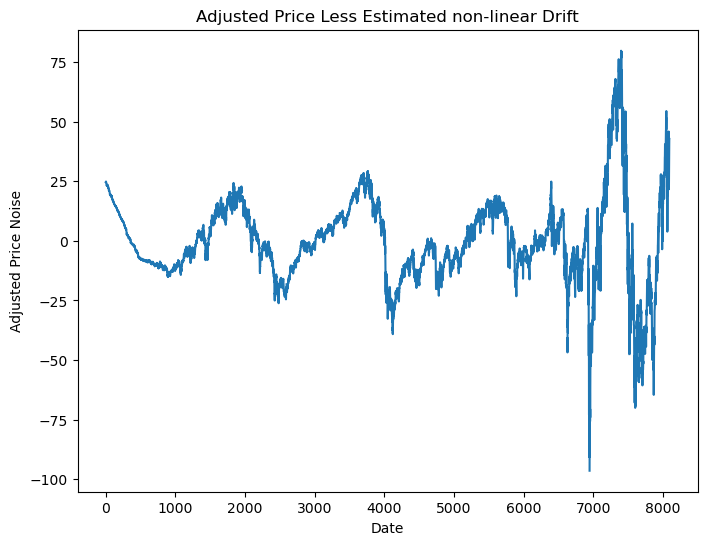

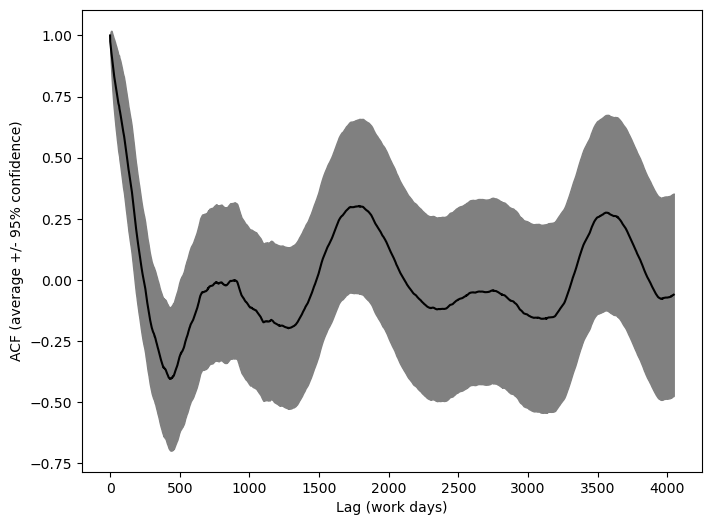

In [70]:

# Define the autocorr funciton
def acf(x,fracLag = 0.5):
    # Get auto corelation function for noise (with 68% confidence interval)
    n = len(x)
    # maximum lag considered is % of total 
    maxLag = int(fracLag*n)

    # Well accepted method
    acf, acfConf = stattools.acf(x,alpha=(1-0.95),nlags=maxLag,missing='conservative')

#    # Rubber meets the road, brute force method to double check (long run time)
#    x = x - np.mean(x)
#    acf = np.zeros(maxLag)
#    acfConf = np.zeros((maxLag,2))
#    for delta in range(maxLag):
#        corr = np.array([])
#        for i in range(n):
#            indLag = i+delta
#            if indLag < n: 
#                corr = np.append(corr,x[i]*x[i+delta])
#        acf[delta] = np.mean(corr)
#        acfConf[delta,0] = acf[delta] + np.sqrt(np.var(corr)/len(corr))
#        acfConf[delta,1] = acf[delta] - np.sqrt(np.var(corr)/len(corr))
       

    return acf, acfConf
    
    
# Remove the drift 
# Recall that we previously dfined y as our target, adjusted closing price
# We also defined yHat_final as our prefered fit




#####

# Calc ACF price

y_ac, y_acConf = acf(y)
print(y_ac)

plt.figure(figsize=(8, 6))
lag = np.arange(len(y_ac))
plt.plot(lag, y_ac,color='black')
plt.fill_between(lag, y_acConf[:,0],y_acConf[:,1],color='gray')
plt.xlabel('Lag (work days)')
plt.ylabel('ACF (average +/- 95% confidence')
#plt.title('')
plt.show()

# Calc ACF price noise, i.e. price - drift, i.e. price - trend 

yNoise = y-yHat_final
yNoise_ac, yNoise_acConf = acf(yNoise)
print(yNoise_ac)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x, yNoise)
plt.xlabel('Date')
plt.ylabel('Adjusted Price Noise')
plt.title('Adjusted Price Less Estimated non-linear Drift')
plt.show()



# Plot the data 
plt.figure(figsize=(8, 6))
lag = np.arange(len(yNoise_ac))
plt.plot(lag, yNoise_ac,color='black')
plt.fill_between(lag, yNoise_acConf[:,0],yNoise_acConf[:,1],color='gray')
plt.xlabel('Lag (work days)')
plt.ylabel('ACF (average +/- 95% confidence)')
#plt.title('')
plt.show()


## IV Sampling Frequency of Returns
Given the result above, we will consider the sampling rate relavant to returns, not price.
We feel this may actually be a more important feature to look at for determining the 
meta parameter of sampling rate since the most relavant statistical parameter is return.

### i Transform to Returns
Our final statistical analysis will be based on monthly returns. 
To simplify this we are considering 30 day periods from time t to t+30 days. 
Since stock is traded when the market is open, so our time series only contains weekdays,
we are removing approximately 2 weekends days per week. 
A 30 day month, given 4.25 weeks each month, yields 8.5 weekend days.
We removed 9 days to account for a handful of holidays.
As a matter of practice, we are considering relative returns.

[   0    1    2 ... 8088 8089 8090]
[ 24.68  24.86  24.91 ... 559.09 562.01 562.84]
[ 0.02309562  0.01971038  0.01204336 ... -0.03470874 -0.03737209
 -0.00694868]
[  0.57   0.49   0.3  ... -19.49 -21.11  -3.87]
[  21   22   23 ... 8067 8068 8069]


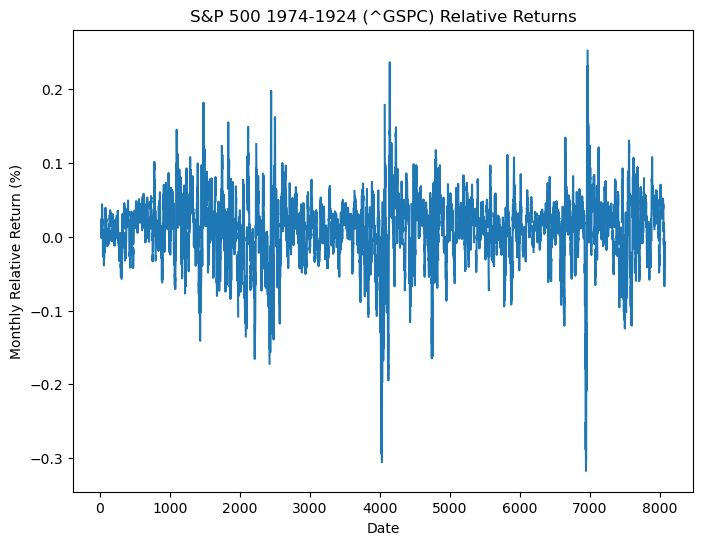

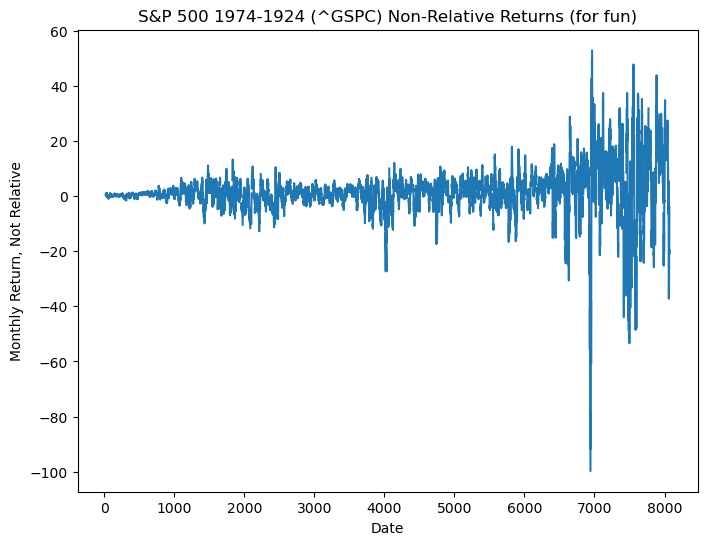

In [71]:
# Just to be sure we know whats what 
x = np.arange(len(spy_history['Adj Close**']))
y = np.array(spy_history['Adj Close**'])

print(x)
print(y)

# Open market days in a month: 30(days per month) - 4.25(weeks in 30 days) * 2(weekend days)
days = 30 - 9
n = len(y)-days

# calculate returns
yReturn = np.zeros(n-days)
yReturn_nonrel = np.zeros(n-days) #just for a fun note
xReturn = []
for i in range(n-days):
    yReturn[i] = (y[i+days] - y[i]) / y[i]
    yReturn_nonrel[i] = (y[i+days] - y[i])
    xReturn.append(x[i+days])

xReturn = np.array(xReturn)

# Show for sanity check
print(yReturn)
print(yReturn_nonrel)
print(xReturn)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(xReturn, yReturn)
plt.xlabel('Date')
plt.ylabel('Monthly Relative Return (%)')
plt.title('S&P 500 1974-1924 (^GSPC) Relative Returns')
plt.show()

# Plot the non relative data for fun
plt.figure(figsize=(8, 6))
plt.plot(xReturn, yReturn_nonrel)
plt.xlabel('Date')
plt.ylabel('Monthly Return, Not Relative')
plt.title('S&P 500 1974-1924 (^GSPC) Non-Relative Returns (for fun)')
plt.show()

### ii Autocorrelation Function
As in Section III, we caculated the ACF to determine the time need 
for samples to be reasonably considered statistically independent.
In this case we use the returns as determined above in Section IV.i.

We found the ACF to drop below zero after 21 days
and to follow closly to zero in an ocilitory pattern thereafter.
The upper bound on the 95% confidence interval does not pass zero
in the first part of the trijectory considered.

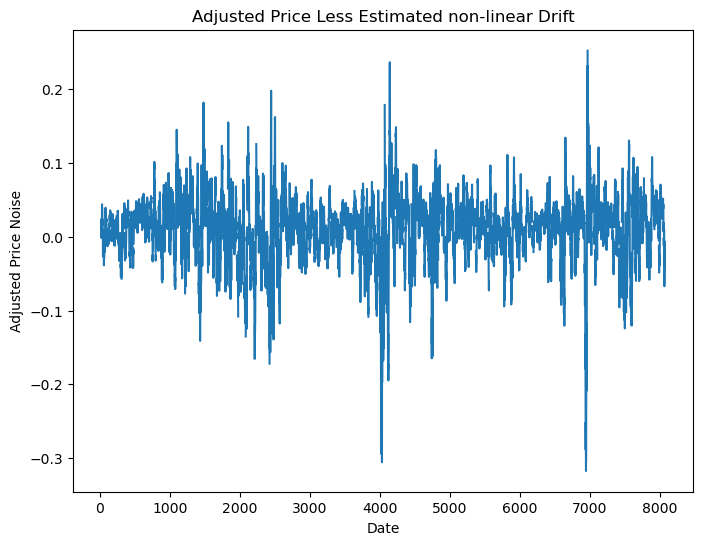

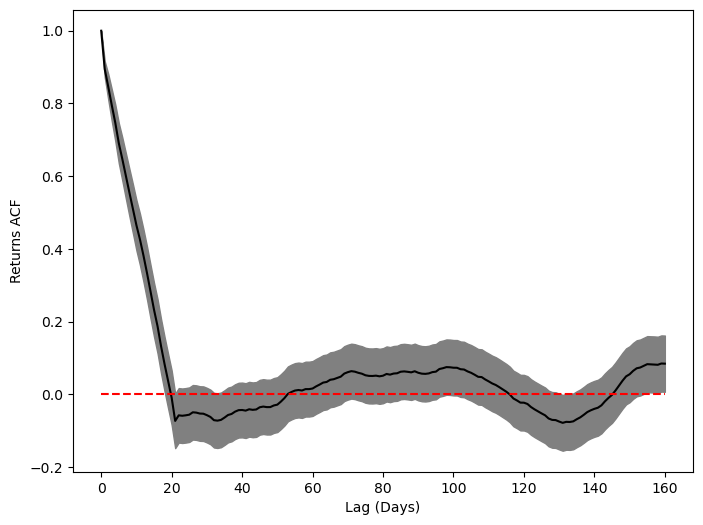

Return ACF
[ 1.00000000e+00  8.94288829e-01  8.45723162e-01  7.95097650e-01
  7.46626704e-01  6.90442517e-01  6.46761921e-01  6.00643878e-01
  5.55071676e-01  5.10442531e-01  4.64864748e-01  4.25994784e-01
  3.81506703e-01  3.33548137e-01  2.82240071e-01  2.32192825e-01
  1.86945342e-01  1.31747109e-01  8.22919352e-02  3.59818248e-02
 -9.42384434e-03 -7.31322057e-02 -5.78093611e-02 -5.89431476e-02
 -5.77347983e-02 -5.59768581e-02 -4.94239509e-02 -5.03374588e-02
 -5.28658267e-02 -5.32955300e-02 -5.72687821e-02 -6.22029884e-02
 -7.11076841e-02 -7.24142658e-02 -7.03283394e-02 -6.40224092e-02
 -5.68747591e-02 -5.40188173e-02 -4.76068094e-02 -4.35551883e-02
 -4.30895373e-02 -4.48353106e-02 -4.11112449e-02 -4.26614097e-02
 -4.16805619e-02 -3.56021066e-02 -3.37096083e-02 -3.51772849e-02
 -3.50918122e-02 -3.06532666e-02 -2.83633912e-02 -2.00843965e-02
 -1.05415359e-02  1.29545519e-03  6.36871453e-03  1.03818466e-02
  1.18507627e-02  1.05442154e-02  1.43377940e-02  1.43150793e-02
  1.59837788e-

In [72]:
# Recall the autocorr funciton is alreaded defined, acf()
# Recall the return is already calculated, yReturn, xReturn
    
# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(xReturn, yReturn)
plt.xlabel('Date')
plt.ylabel('Adjusted Price Noise')
plt.title('Adjusted Price Less Estimated non-linear Drift')
plt.show()    

# Calc autocorr
yReturn_ac, yReturn_acConf = acf(yReturn,fracLag=0.02)
lag = np.arange(len(yReturn_ac))


# Plot the data for sanity check
plt.figure(figsize=(8, 6))
lag = np.arange(len(yReturn_ac))
plt.plot(lag, yReturn_ac,color='black')
plt.plot(lag, np.zeros(len(lag)),'--',color='red')
plt.fill_between(lag,yReturn_acConf[:,0],yReturn_acConf[:,1],color='gray')
plt.xlabel('Lag (Days)')
plt.ylabel('Returns ACF')
#plt.title('')
plt.show()
print('Return ACF')
print(yReturn_ac[:150])
print('Return ACF 95% Conf')
print(yReturn_acConf[:150])


### iii Sampling Frequency
Based on the results in Section IV.ii, 
we concluded that the sampling frequency 
must be higher that 21 days and that, 
while some minor negative correlations may exist,
there is no major deviation from zero over time.
To this end, we have decided to use 
42 days as the sampling period for 
determining a 21 working day return (or ~30 day return or ~1 month return).

In all cases we see the AC clearly overshoot the zero and go into negative correlation.
This is typical in many non-linear dynamic systems
as apposed to a smooth approach towards zero.
In addition, while the zero does remain in the 95% CI for all time after the initial zero,
it is certainly not within the 66% CI.
Later we define the 33% most extreme deviations as 'abnormal' events.
Events that are actually expected but not typical (outside one st. dev. for normal dist data).
This means that by our own definitions the zero is only held within the CI by 
abnormal or atypical events.
When we restructure the code for more systematic use in the future, 
we should put more consideration into thesholds and rules for choosing 
a value for sampling freq.
This may include shrinking the CI and/or including a requirement for the 
zero to remain within the CI for a set period of time.
Given some of the long-term memory, this may be tricky.

Personal note, it may seem counter intuitive that shrinking the CI leads to more conservative estimates;
however, in this case the CI is being used a bit backwards.
If we wanted to make a claim that the AC is *x*% *not* zero, higher CI would be more conservative.
Here, we are trying to claim that it is, within reason, near zero.
We want to look where most of the data is falling and ignore the more uncommon cases.
Consider choosing a CI of 100%. The error bounds would be +/-inf, 
and all lag values would contain zero.
Alternatively, a CI of 0 would be bounds of +/-0, only discrete points 
where the AC crosses the x-axis would the value contain zero.




8091
193


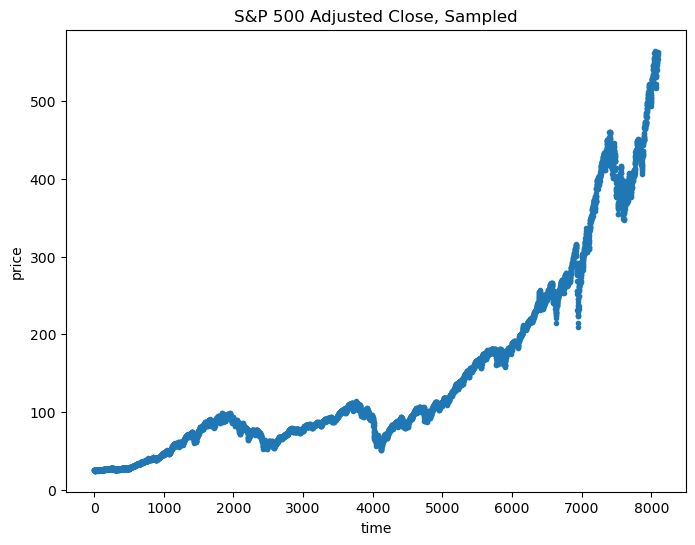

8049
192


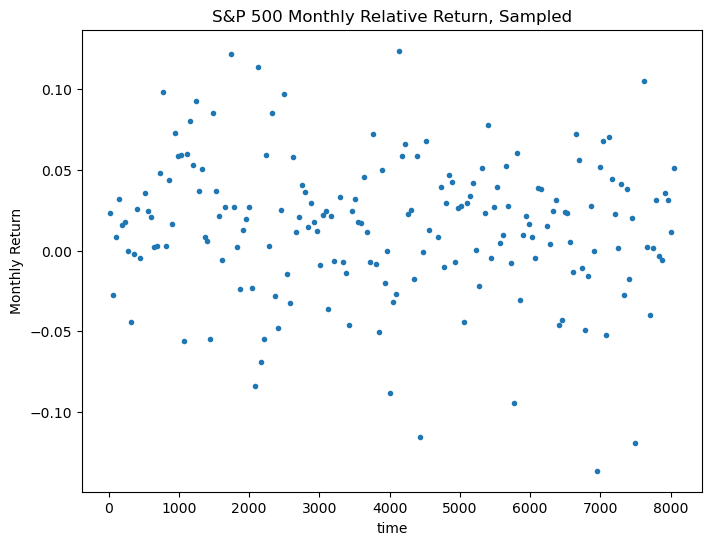

In [73]:
delta_return = 21
delta_sf = 42
n = len(spy_history['Adj Close**'])
print(n)
inds = np.arange(0,n,delta_sf)

x = np.arange(len(spy_history['Adj Close**']))
y = np.array(spy_history['Adj Close**'])
x_samp = x[inds]
y_samp = y[inds]
print(len(x_samp))
# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x,y,'.')
plt.xlabel('time')
plt.ylabel('price')
plt.title('S&P 500 Adjusted Close, Sampled')
plt.show()

# *** depending on returns from above section ***
n = len(xReturn)
print(n) 
inds = np.arange(0,n,delta_sf)
xReturn_samp = xReturn[inds]
yReturn_samp = yReturn[inds]
print(len(xReturn_samp))
# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(xReturn_samp,yReturn_samp,'.')
plt.xlabel('time')
plt.ylabel('Monthly Return')
plt.title('S&P 500 Monthly Relative Return, Sampled')
plt.show()

## V Identify Pricing Deviations
Given the sampling frequency determined above, in Section IV.iii,
we revisited the pricing data in order to 
recalculate systemic drift and pricing deviations (previously referred to as noise). 

### i Re-Assessing Trends for Systemic Drift 
Here we used the same basic code as in Section II, 
but we apply it to the properly sampled data to confirm.
We again found the 4th order polynomial to be the best fit.

Personal note, looking at the sampled data only (every 42 trading days) for deviations 
something possibly interesting popped out.
From this view it seems like there is a clear, simple, contiguous pattern 
of deviation over-under-repeat, but in day 4500 the pattern 
starts to degrade and by day 7000 it is all but gone.
This corresponds to 2009 and 2020 - the housing and COVID19 crisis, respectively.
In particular, these are the times when massive government spending was used to mitigate damages.
This spending included bailing out major financal institutions in 2009 
and dumping 100s of billions into the markets in 2020-2022.
Both of these actions are essentially directly tied to artificially pumping up the market.
This is more direct than a fed intrest rate change and far more direct than 
giving money to would-be consumers that *may* in turn spend and then increase the market indirectly.
Once again this is a suggestion that big players, both government and industry, 
try to push the market higher than it can naturally maintain, 
and when they do the it always leads to fall out in terms of large market swings
(e.g. bursting bubbles and wild volatility).


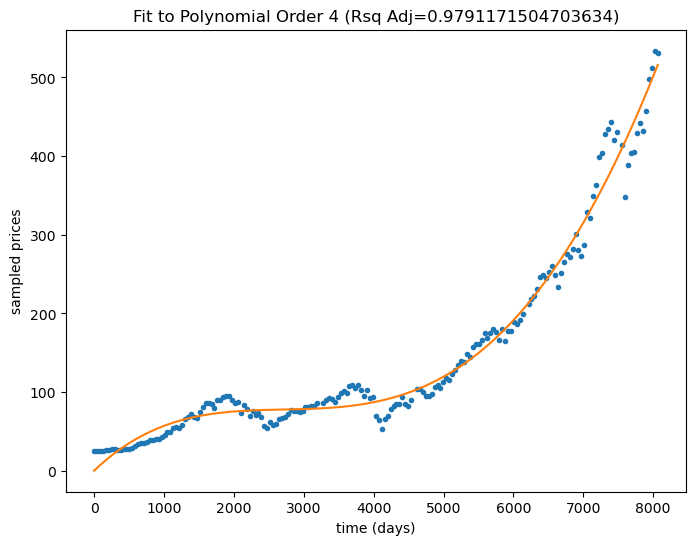

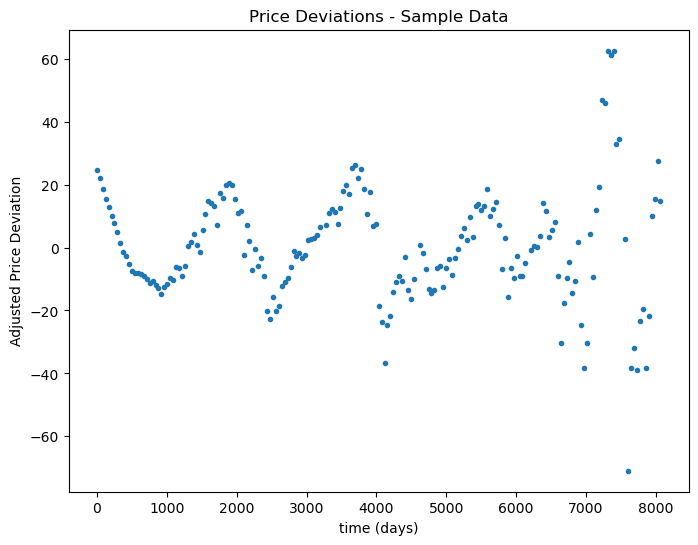

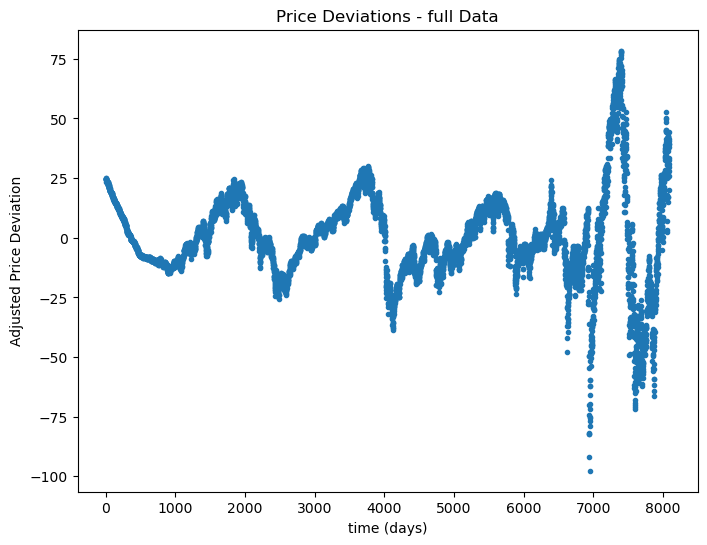

In [74]:

 
# maximum order of polynomials (we exclude 0th) *USER SET*
maxPolyOrder = 6

def run_model(X,y):
    # statsmodels ordinary least squares regression model
    regr = OLS(y, X, missing='drop').fit()
    ic = regr.bic
    rsq = regr.rsquared_adj
    yHat = regr.predict(X)
    
    return ic, rsq, yHat, regr

# given repeted use we are going to define a function for this

def pickSimpModel(x,y,maxPolyOrder):

    nameBest = ''
    modelBest = ''
    yHatBest = []
    rsqAdjBest = 0 
    # we decided to use adjusted r squared here because the ics
    # calculated in stats ols function are not comparable if a
    # variable transformation is done on y prior to the function
    # call, which is what we do in exp.
    # However, this should not be an issue given the small number 
    # of parameters for these models.
    if len(y) < maxPolyOrder*4: 
        print('Warning: Low obs to order, double check model selection criterion')

    # Run through all poly deg models
    for i in range(maxPolyOrder):
        polyOrder = i+1
        name = 'Polynomial Order '+str(polyOrder)

        # Create X matrix
        if polyOrder == 1:
            X = add_constant(x.reshape(-1, 1))
        else:
            X = np.c_[X, x**polyOrder]

        ic, rsqAdj, yHat, model = run_model(X,y)
        
        if rsqAdj > rsqAdjBest:
            rsqAdjBest = rsqAdj
            nameBest = name
            modelBest = model
            yHatBest = yHat
        
    


    ### Run for exp function: y=Aexp(Bx) -> log(y)=log(A)+Bx
    name = 'Exp Function'

    X = add_constant(x_samp.reshape(-1, 1))
    ic, rsqAdj, yHatLog, model = run_model(X,np.log(y))
    
    if rsqAdj > rsqAdjBest:
        rsqAdjBest = rsqAdj
        nameBest = name
        modelBest = model
        yHatBest = np.exp(yHatLog)


    ### Run for log function: y=A+Blog(x)
    name = 'Log Function'

    X = add_constant(np.log(x_samp+1).reshape(-1, 1))
    ic, rsqAdj, yHat, model = run_model(X,y)

    if rsqAdj > rsqAdjBest:
        rsqAdjBest = rsqAdj
        nameBest = name
        modelBest = model
        yHatBest = yHat


    return rsqAdjBest, nameBest, modelBest, yHatBest



rsqAdjBest, nameBest, modelBest, yHatBest = pickSimpModel(x_samp,y_samp,maxPolyOrder)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x_samp, y_samp,'.',x_samp,yHatBest,'-')
plt.xlabel('time (days)')
plt.ylabel('sampled prices')
plt.title('Fit to '+nameBest+' (Rsq Adj='+str(rsqAdjBest)+')')
plt.show()

################

yNoise = y_samp-yHatBest

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x_samp, yNoise, '.')
plt.xlabel('time (days)')
plt.ylabel('Adjusted Price Deviation')
plt.title('Price Deviations - Sample Data')
plt.show()

x = np.arange(len(spy_history['Adj Close**']))
y = spy_history['Adj Close**']


## Deviations in full data set
# just in-case we want to look at it but
# using the model built on properly spaced sample data

# recall that we did some manipulation before calling the model
# now we need to do it again
# in the future we should write in a function to solve for this issue
# to avoid human error
for i in range(4):
        polyOrder = i+1
        # Create X matrix
        if polyOrder == 1:
            X = add_constant(x.reshape(-1, 1))
        else:
            X = np.c_[X, x**polyOrder]

yNoise_full = y-modelBest.predict(X)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x, yNoise_full, '.')
plt.xlabel('time (days)')
plt.ylabel('Adjusted Price Deviation')
plt.title('Price Deviations - full Data')
plt.show()
    

### ii Identifying Price Trend Deviations
Using median as a robust analogue to the sample mean, and 
we are defining Median Absolute Trend Deviation (MATD) as the deviation from trend.
Median Absolute Deviation (MAD) is commonly used as a robust analogue to the sample standard deviation,
which we will use later to estimate a volatility metric.
Here, we define a modified form, MATD, as median of the absolute deviation from the *trend* or drift.
We are then using an ordering to identify the 68%, 95% and 99.5% most extreme values.
This is similar to one, two and three standard deviations, respectively, for a normal distribution. 
We are defining these extremes as abnormal, semi-rare and rare event, respectively.
By definition an set number of deviations, depending on sample size, 
will fall into these cases despite there actual magnatudes;
therefore, this is relative only to itself and not an indication of effect size.
We also note that abnormal deviations are the highest 32%,
which we consider atypical (reasonably outside the majority), 
but expected over time for any mid to long-term portfolio hold.

Personal note, we may want to revisit using the MATD estimate with the correction factor of 1.48
for the event thresholds.
This is the correction factor (given large sample sizes; small sample size factors can be found from lit online)
for MAD and St. Dev.
This would replace the sort and put a bit more emphasis on the values.
For example, one corrected MATD may not be equivalent to 32% as it would rely on the underlying distribution, 
which may not be normally distributed.

In [75]:
#  CDefine the Thresholds *USER SET*
def thresh(x):
    frac_ab = 0.68 # abnormal event - equivlant to 1 stdev 
    frac_sr = 0.95 # semi-rare event - equivlant to 2 stdev
    frac_r = 0.995 # rare event
    n = len(x)
    x_sorted = np.sort(x)

    thresh_ab = x_sorted[int(n*frac_ab)]
    thresh_sr = x_sorted[int(n*frac_sr)]
    thresh_r = x_sorted[int(n*frac_r)]
    return thresh_ab, thresh_sr, thresh_r

# We are working with robust stats so shift to the median (need to manually remove NaNs)
missing = np.isnan(yNoise)
keep = np.invert(missing)
yNoiseAdj = yNoise[keep]
yNoiseAdj = yNoiseAdj - np.median(yNoiseAdj)
# there is a lot of down stream code that relies on the order, now need to drop values from all those
# this is a hack for now, will improve when we restructure code for more automated use
x_sampAdj = x_samp[keep]
y_sampAdj = y_samp[keep]


# for deviations, we dont care if they are positive or negative
yDev = np.abs(yNoiseAdj)

print(str(np.median(yDev)))

# Caclulat threshold values
thresh_ab, thresh_sr, thresh_r = thresh(yDev)

# Print for sanity check
n = len(yDev)
print(n)
print(str(thresh_ab)+' - '+str(int(n-.68*n)))
print(str(thresh_sr)+' - '+str(int(n-.95*n)))
print(str(thresh_r)+' - '+str(int(n-.995*n)))


10.540865538351284
189
14.494785151722084 - 60
37.572552447576754 - 9
70.1908720925436 - 0


### iii Event and Lengths
Here we seek to provide grounding for investors 
in times when the market may be visually deviating from our preconceived expectations.
As we mentioned above in sub section ii, 'abnormal' deviations are atypical,
extreme compared to the majority, but should be expected for mid- to long-term holds.
If deviations occur in series, there would be a benefit to have some 
reasoned insight on how often such deviation event occur and how long they typically last.
To this end, we considered the extreme deviations in more detail.
Specifically, when a deviation was identified as deviation >= extreme event threshold 
it is marked as the start of a deviation event, which was considered to continue, 
proceeding over all consecutive time points, 
until it dropped below the event threshold; 
therefore, determining the overall events length.

We found 18 abnormal events 
(defined as 32% of the most extreme price deviations from an expected trend)
with a median of 84 open market days (~four months).
Abnormal events lasted from about two to 18 months.
Based on these numbers it would be reasonable for investors 
to wait at least four months before making any major changes 
(beyond rebalancing) to ones portfolio even in the face 
of sudden, seemingly unexpected, market change. 

In a mid- to long-term hold strategy it is unwise to 
sell or buy stocks after a sudden downward drop or upward spike, respectively.
The data tells us to expect this behavior and that it will
correct itself after a short to moderate amount of time.
Continued, systematic rebalancing to maintain pre-event
investment allocation levels should not only offset the 
negative impact of these events, 
but may lead to larger returns under the assumption
that levels will return to expected trends.
As the market falls below trend expectations, 
rebalancing will actually purchase more stocks - 
consistant with the buy low strategy.
Upon market correction 
you should see a net gain as the temporarily low price return to higher levels.

Of course events may still occur that have not been seen before,
and the market is always changing - sometimes in fundmental ways.
This is why reallocation (reassessing portfolio optimisation) is 
critical for long-term portfolio holds.
The heuristic result of reallocating every four months could be a 
reasonable way to balance the trade-offs
of acting too quickly and not acting at all.

Personal note, there are no semi-rare or rare deviation events pre COVID19 pandemic. 
Although there are semi-rare events even after the economic recovery from the pandemic.
This may suggest that the pandemic had a long-lasting, fundamental impact on the market.
The negative impact on markets from shutdowns would be obvious, 
but there are semi-rare events that include rapid market increases.
The pandemic and post pandemic maket are not simply a product of 
sudden market depression and recovery, 
but rather the start of massive and continued market *volatility*.
This is consistant with the findings above in sub-section ii 
(increased, long-lasting volatility in monthly returns in 2009 and more so in 2020).

Although, there is no clear proof, one could suggest the increased 
volatility is due to government intervention *directly* in the market.
It is worth nothing that the US government continued to funnel billions 
directly into the markets even after a resonable post-pandemic market recovery had taken hold.
This is not an inditement; however, it is another observation that 
direct government intervention on behalf of the financial sector 
with the goal of artificially maintaining or increasing the value 
of financal institutions and/or assets (i.e. artificially inflating the market by direct action)
leads to increased, long-term volatility.


Threshold: 14.494785151722084
Number of Events: 18
Median Event Length: 84.0
Event Lengths:
[ 42  42  42  42  42  42  42  84  84 126 168 210 210 252 336 336 378]
Total Time:
2478


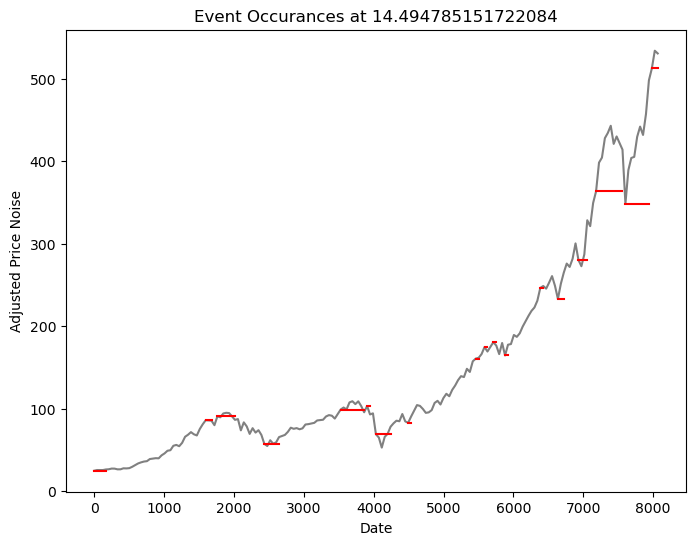

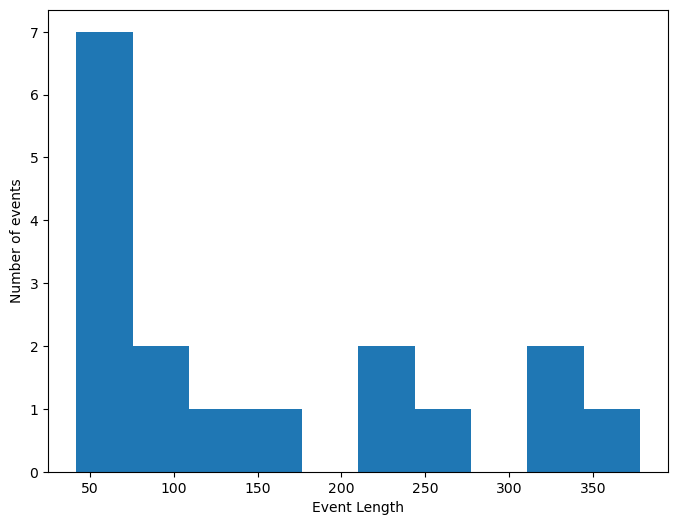

Threshold: 37.572552447576754
Number of Events: 5
Median Event Length: 42.0
Event Lengths:
[ 42  42  42  84 210]
Total Time:
420


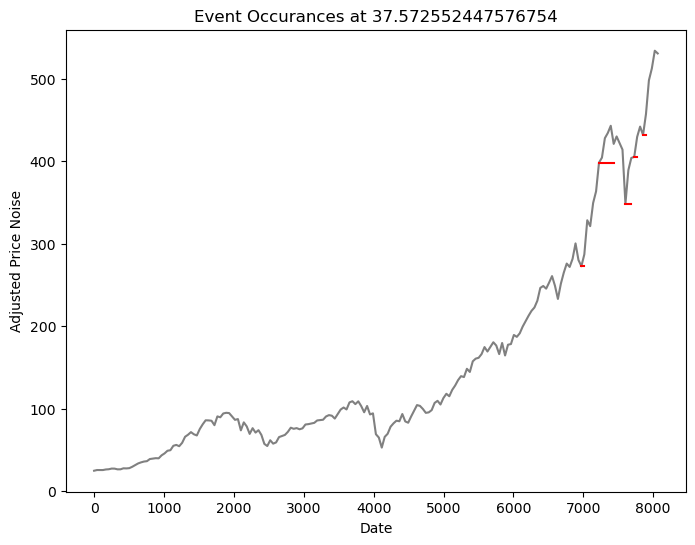

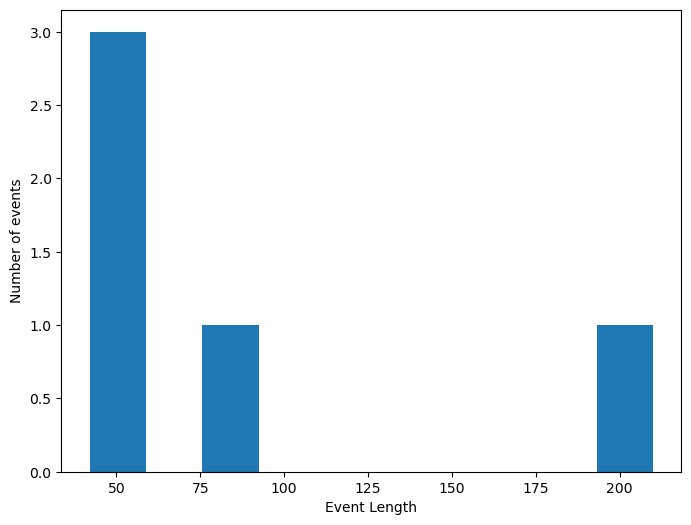

Threshold: 70.1908720925436
Number of Events: 1
Median Event Length: 42.0
Event Lengths:
[42]
Total Time:
42


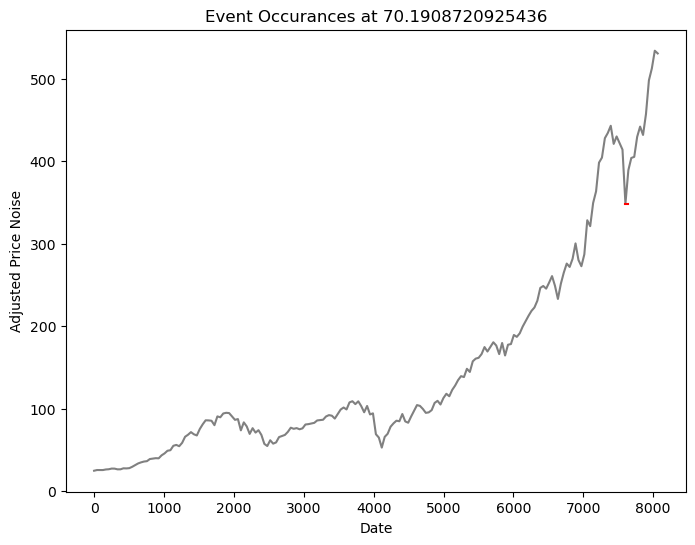

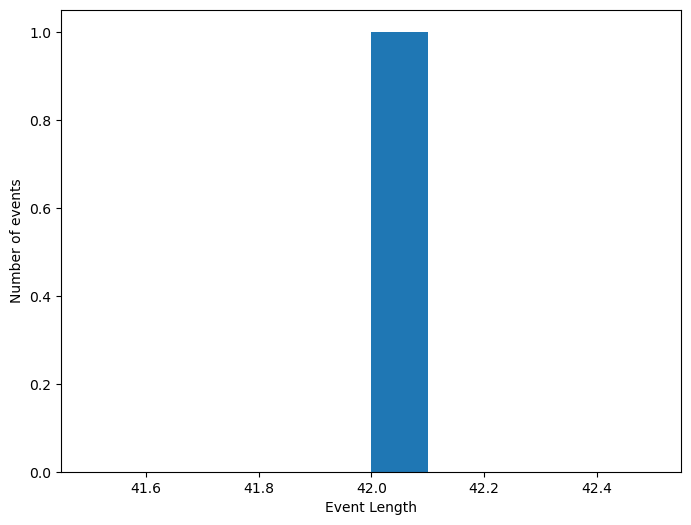

In [76]:
# Define event finder



def flagEvents(time,value,thresh):
    n = len(time)
    event_time=[]
    event_ind=[]
    event_length=[]
    started=False 
    for i in range(n):
        if (value[i]>=thresh) and (started==False):
            started=True
            event_time.append(time[i])
            event_ind.append(i)

            start_time=time[i]
        elif (value[i]<thresh) and (started==True):
            started=False
            end_time=time[i]
            event_length.append(end_time-start_time)
            
    return event_time, event_length, event_ind

for thresh in [thresh_ab, thresh_sr, thresh_r]:


    event_time, event_length, event_ind= flagEvents(x_sampAdj,yDev,thresh)

    
    print('Threshold: '+str(thresh))
    print('Number of Events: '+str(len(event_time)))
    print('Median Event Length: '+str(np.median(event_length)))
    print('Event Lengths:')
    print(np.sort(event_length))
    print('Total Time:')
    print(np.sum(event_length))
    inds = np.array(event_ind)
    # Plot the data for sanity check
    plt.figure(figsize=(8, 6))
    plt.plot(x_sampAdj, y_sampAdj,color='gray')
    for i in range(len(inds)):
        ind = inds[i]
        event_x0 = x_sampAdj[ind]
        if i == len(event_length): # if last event has not finished, it wont have a length yet
            event_xt = x_sampAdj[-1] # we are setting these events to end at the time frame end
        else:
            event_xt = event_x0 + event_length[i]
        event_y = y_sampAdj[ind]
        plt.plot([event_x0,event_xt],[event_y,event_y],color='red')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Price Noise')
    plt.title('Event Occurances at ' + str(thresh))
    plt.show()
    plt.figure(figsize=(8, 6))

    plt.hist(event_length)
    plt.xlabel('Event Length')
    plt.ylabel('Number of events')
    plt.title('')
    plt.show()



# *** Consider doing the full time course, will need to re assess the yHats, which means we needed to save the modle from before




## VII. Portfolio Holding Time
A simple analysis was done regarding the average portfolio return 
depending on portfolio hold time.
We suggest that the longer a portfolio is held, the high the return.
We looked at relative returns in one month increments from zero to over about 11 years.
Averages were taken over the full SPY time course used above (1993-2024).
There was a linear dependance with a slope of 13.3% from hold times of 0 to 6 years; 
however, the median returns demonstrated an unexpected drop for hold times between 6-8 years.
Following this drop, the median returns were again linear from 8 to 11 year hold times;
although now with an increased slope of 16.5% per year.
Without the drop the median return of SPY would have been close to the S&P, 
which was about 17% per year regardless of how long the S&P portfolio was held.
In the case of SPY, however, the drop at 7 years put the 10 year hold at 11.3% -
significantly lower than the S&P 500.
So 10,000 USD in SPY for 10 years would have yielded 21,300 USD, 
but if the portfolio was perfectly consistant with the S&P it would have yielded
27,000 USD - nearly a 30% higher return.
If the calculations were correct, it suggests that SPY an inefficient replica of the S&P 500.
On a personal note, I do think an under performing asset is better than an over inflated one.
We should repeat this for other passive ETFs representing the S&P 500 index 
before suggesting a proper market surrogate. 
It is important to emphasize that this is the median over the full time seris;
thus, a investing in SPY for 7 years was typically less profitable than investing for only 6
regardless of if that investment was made in the 1990's or perhaps the 2010's.
It is also worth recalling the 7 year periodicity in the ACF of SPY's price deviation. 


Interestingly, both the lower and upper 95% CI bounds increased as the median decreased.
In fact, this period was the only hold time where the lower 95% CI return was above zero -
in some sense the safest length to hold SPY was about 7 years.
The lower bound for SPY had very similar behaviour as the S&P 500;
although, there was not enough data to properly carry it out as far 
to see if 12+ year holds again rise above 0 as they did in the S&P 500.
From this perspective the SPY seems to have the same minimal (but typically not zero) downside risk.
The upper boud, however, was not similar to the S&P 500 as it also showed a significant drop 
where as the S&P 500 upper bound showed an essentially monotonic increase.
This limits upside opportunities in SPY. further putting it into question as the 'right' S&P ETF.
It's worth noting that this drop in the upper bound occurred after the drop in the median.

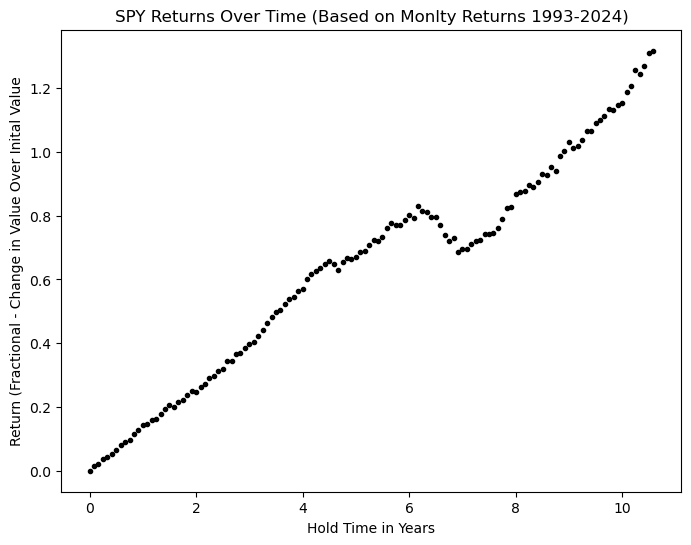

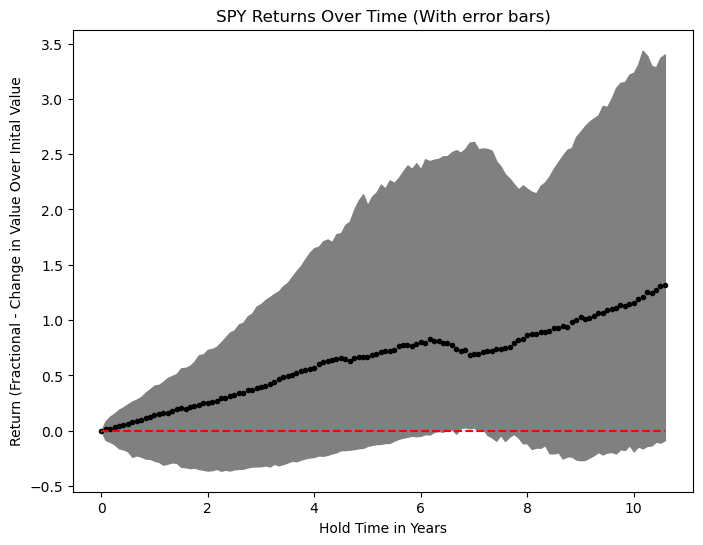

In [82]:
def returnFunc(a,b):
    return (b-a)/a
    
def calcRunningReturns(x):
    
    n = len(x)
    returns = np.array([])
    confup = np.array([])
    confdn = np.array([])
    lags = np.array([])
    
    for lag in range(int(n/3)):
        
        temp = []
        for j in range(0,n-lag,1):
            if not np.isnan(x[j]) and not np.isnan(x[j+lag]):

                temp.append(returnFunc(x[j],x[j+lag]))
                
        temp = np.sort(temp)
        m = len(temp)
        
        indUp = int(m/2) + int(m*.475) # index for the first in the top 95% 
        indDn = int(m/2) - int(m*.475) # index for the firt in the bottom 95%

        returns = np.append(returns,np.median(temp))
        confup = np.append(confup,temp[indUp])
        confdn = np.append(confdn,temp[indDn])
        lags = np.append(lags,lag)
        
    return returns, np.c_[confup,confdn], lags

y = spy_history['Adj Close**'].to_numpy()
# monthly
inds = np.array(range(0,len(y),21))
returns, conf, lags = calcRunningReturns(y[inds])

plt.figure(figsize=(8, 6))
plt.plot(lags/12,returns,'.',color='black')
#plt.fill_between(lags/12,stDev*2+returns,returns-stDev*2,color='gray')
plt.xlabel('Hold Time in Years')
plt.ylabel('Return (Fractional - Change in Value Over Inital Value')
plt.title('SPY Returns Over Time (Based on Monlty Returns 1993-2024)')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(lags/12,returns,'.',color='black')
plt.plot(lags/12,returns*0,'--',color='red')
plt.fill_between(lags/12,conf[:,0],conf[:,1],color='gray')
plt.xlabel('Hold Time in Years')
plt.ylabel('Return (Fractional - Change in Value Over Inital Value')
plt.title('SPY Returns Over Time (With error bars)')
plt.show()

## VIII. Determining Sampiling Period
The mean-value analysis of Modern Portfolio Theory relies on 
statistical estimates of a return and risk parameter.
As mentioned above, we considere median realitive monthly returns and corresponding MAD.
To calculate these metrics, we need a proper sampiling frequency (determined in Section IV.iii)
and a sampiling period (in this case number of consecutive months to analyze over).

Previous analysies have shown that short sampiling periods lead to 
low-biased estimates of risk, as expected with small sample sizes.
However, long sampling periods (10, 20, 50 years) may not be avalible,
require additional copute resources and may not hold information relavant 
to the current market.

The question is, how long is long enough.
We caclulated the risk parameter over different period 
lengths in the S&P 500 from 3 to 200 months.
As expected the value start relativly low but quickly becomes 
relativly stable, at higher risk estimates, over longer sampiling periods.

We also caclulated the estimated return parameter and compared it 
to the 'acutaul' return at 1, 6 and 12 months following the sampiling period.
From this the absolute deviation was taken, which is comparable to our 
estimated or 'predicted' risk parameter. 
In estimating all parameters, we appilied a temporal cross-validaition study 
that allows us to average (or in this case take the meadian) over a moving time 
window, which provides increased statistical power, particularly for shorter sampiling periods.

We found, at least in the case of the S&P 500,
our deviation between predictive and actual returns to 
generally decrease with increasing sampiling period  
up to the full 200 months.
We note that it is not perfectly monotonic, 
which may be due to statistical noise or 
low, but seemingly relavant, long-term memory ocilations in the market
as described above and else where.
We also noted that both prdicted and actual deviation show
clear signs of flatening out, or approaching an asymptote.
While it would be favorable if both clearly, stabally approched the 
same asymtotic point, statistical noise and the nature of the 
data made that impossible even for a long lived index like the S&P 500.
It's also likly that there are diminishing returns to only considering 
very long sample periods in future portfolio analysis including 
the lack of data for many assets and other confounding facotrs 
(known or otherwise) that also contribute to errors.

To this end, we chose to treat the both trajectories 
similar to that of an exponental decay, caclulate 
an approximate asymptotic value and use a decay 
of 90% (arbitrarily chosen) as the cutoff.
We will use the maximum of the two cutoffs 
(predicted vs actual) for the sampiling period moving forward.

However, upon trying this, even with a hack in place, 
we found the decay was not appropriate.
Althought, a model could be formed from a non-linear 
(possibbly logistic) function, we belived this was unnecasarily complicated 
and would be difficult to easily interpret the results.
For our purposes we wanted somthing more straight forward.
We chose to purse a 2-piecewise linear function.
Here the cuttoff for the functions could easily searve as a cuttoff for the needed period.
This would be particularly true if the slopes were drastically different.
We used the mean value with a slight bias towards shorter cutoff periods as the slection criteria.
The maximum of predicted vs actual deviation cutoff was then chosen.





Test for Convergance
- Did Converge
- time = 42.0
- p = 0.3203125

Test for Break
- Pred
-- rsq = 0.6079212712337112
-- time = 7.0
- Act
-- rsq = 0.764824271374939
-- time = 118.0


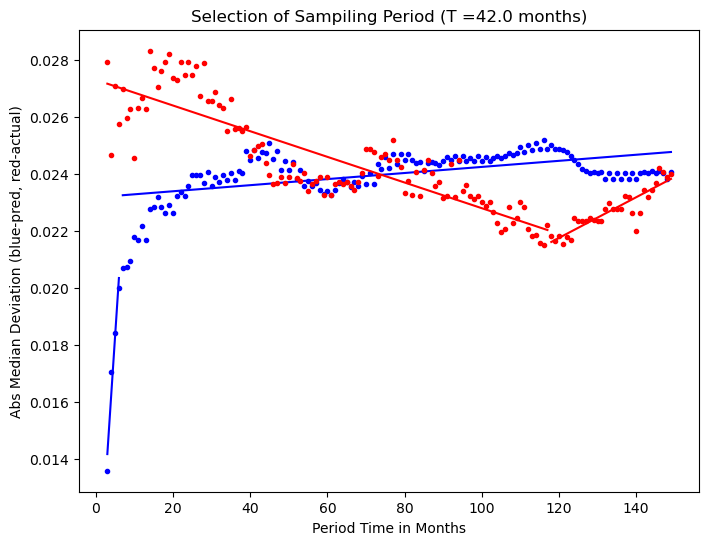

In [107]:

def calcRunningDev(x,periodMin,periodMax,predHor):
    
    
    n = len(x)
    devPred = np.array([])
    devAct = np.array([])
    periods = np.array([])
    
    for period in range(periodMin,periodMax,1):
        
        devPred_current = []
        devAct_current = []
        for j in range(period,n-predHor,1):
            temp = x[j-period:j]
            med = np.median(temp)
            devPred_current.append(np.median(np.abs(temp-med)))
            devAct_current.append(np.abs(med-x[j+predHor]))
            

        devPred = np.append(devPred,np.median(devPred_current))
        devAct = np.append(devAct,np.median(devAct_current))
        periods = np.append(periods,period)
        
    return devPred, devAct, periods

def trendConv(x1, x2, period=12, pCutoff = .1):
    """Here we determine if and when two trends
    converge in the sense that over a given period 
    they are not statistically different.
    the wilcoxon signed-rank test is used 
    to make this determination.
    We note that lack of rejecting the null hypothisis 
    is not equivlant to accepting the null, 
    but given that the stats are compared over tests on 
    sample data that represents the same variable 
    and the same number of observations, 
    we aregue that it is at least reasnable to determine 
    when value are relativly similar.
    """
    # if no convergance is found set defulat returns
    p = 1
    time = 0
    
    n = len(x1) # x1 and x2 must be same length
    
    inds = np.arange(0,period-1,1) # first set of values to test

    for i in range(0,n-period,period):
        wstat = wilcoxon(x1[inds+i],x2[inds+i])
        p = wstat.pvalue
        time = i + .5*period 
        if  p > pCutoff: break

    return time, p


def doubleLinearFunc(x,y):
    rsqBest = 0
    indBest = 0
    criteriaBest = 0
    yHat1Best = []
    yHat2Best = []
    x1Best = []
    x2Best = []
    n = len(y)
    for i in range(3,n-3,1):
        x1 = x[:i]
        y1 = y[:i]
        x2 = x[i:]
        y2 = y[i:]
        # Create X matrix
        X1 = add_constant(x1.reshape(-1, 1))
        ic1, rsqAdj1, yHat1, model1 = run_model(X1,y1)
        X2 = add_constant(x2.reshape(-1, 1))
        ic2, rsqAdj2, yHat2, model2 = run_model(X2,y2)
        rsq = (rsqAdj1 + rsqAdj2)/2
        criteria = rsq * (1 - .1*(i/n))
        if criteria > criteriaBest:
            criteriaBest = criteria
            rsqBest = rsq
            indBest = i
            yHat1Best = yHat1
            yHat2Best = yHat2
            x1Best = x1
            x2Best = x2
    return x1Best, yHat1Best, x2Best, yHat2Best, rsqBest, x[indBest]
            
        
######## workflow ############


y = spy_history['Adj Close**'].to_numpy()
# monthly returns
wkdys = 21
returns = np.array([])
for i in range(0,len(y)-wkdys,wkdys):
    if not np.isnan(y[i]) and not np.isnan(y[i+wkdys]):
        returns = np.append(returns,returnFunc(y[i],y[i+wkdys]))

# get predicted and actual deviations on returns estmiats vs actual

devPred, devAct, periods = calcRunningDev(returns,3,150,6) # 

# first look for convergance
time,p = trendConv(devPred, devAct, period = 12, pCutoff=.1)

print('Test for Convergance')
if time > 1:
    print('- Did Converge')
else:
    print('- Did NOT Converge')

print('- time = '+str(time))
print('- p = '+str(p))
    

# fit to modified decay function
#rsqAdjPred, yHatPred, modelPred = expDecayHackFun(periods,devPred)
#rsqAdjAct, yHatAct, modelAct = expDecayHackFun(periods,devAct)

x1Pred, yHat1Pred, x2Pred, yHat2Pred, rsqPred, cutoffPred = doubleLinearFunc(periods,devPred)
x1Act, yHat1Act, x2Act, yHat2Act, rsqAct, cutoffAct = doubleLinearFunc(periods,devAct)

print('')
print('Test for Break')
print('- Pred')
print('-- rsq = '+str(rsqPred))
print('-- time = '+str(cutoffPred))
print('- Act')
print('-- rsq = '+str(rsqAct))
print('-- time = '+str(cutoffAct))

if time > 1:
    T = time 
else:
    T = np.max([cutoffAct,cutoffPred])


plt.figure(figsize=(8, 6))
plt.plot(periods,devPred,'.',color='blue')
plt.plot(x1Pred,yHat1Pred,color='blue')
plt.plot(x2Pred,yHat2Pred,color='blue')
plt.plot(periods,devAct,'.',color='red')
plt.plot(x1Act,yHat1Act,color='red')
plt.plot(x2Act,yHat2Act,color='red')


plt.xlabel('Period Time in Months')
plt.ylabel('Abs Median Deviation (blue-pred, red-actual)')
plt.title('Selection of Sampiling Period (T ='+str(T)+' months)')
plt.show()


## IV Application for Managment  
Can we use the sampling rate here for portfolio analysis in general?
Does Event Length (EL) help us determine a sampling period for portfolio analysis in general?
Does EL help us determine a hold or portfolio re-balancing strategy?

### i. Some Messy Stuff

### ii. Some Interesting Stuff
 

### iii. Some Crtical Stuff to Move Project forward
* Defining a month as 22 consecutive time points in stock closing data as markets are closed on weekends and holidays.
* Suggesting a rebalancing every month given monthly investment deposits (using buy only strategy to avoid transaction friction calculations)
* Suggesting a reallocation (reoptimization) every 6 months (126+ consecutive time points) and no earlier as this is the time of a typical (median) abnormal deviation event (which is abnormal but still to be expected at nearly 1/3 of all deviations).  
* Setting sampiling frequency as 23 or more days as AC drops to zeros, *resonably*, and holds within 95%.
* Setting sampiling period to 902 days (41 months or ~3.5 years) as it takes this amount of time to switch from a steep to flat slope in the estimate between actual and predicted returns over 6 months (our suggested reallocation freq).

## X. Next Steps